In [1]:
%run 0_3_configure_mlflow.ipynb

Experiment_id: 1
Artifact Location: file:///E:/Studia/Inzynierka/csgo-analysis/notebooks/mlruns/1
Tags: {}
Lifecycle_stage: active


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import shap
import os
import shutil

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, f1_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibrationDisplay
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Wczytanie danych

In [3]:
df = pd.read_parquet('data/states_another_mod.parquet')
df

,filename,mapName,ctBuyType,tBuyType,winningSide,matchID,roundNum,seconds,ctAlivePlayers,ctEqVal,...,de_ancient,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_vertigo,bombsite_A,bombsite_B,bombsite_not_planted
0,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,0.148438,5,3700,...,0,0,0,1,0,0,0,0,0,1
1,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,0.398438,5,3700,...,0,0,0,1,0,0,0,0,0,1
2,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,0.648438,5,3700,...,0,0,0,1,0,0,0,0,0,1
3,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,0.898438,5,3700,...,0,0,0,1,0,0,0,0,0,1
4,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,1.148438,5,3700,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3186232,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,19.765625,1,30150,...,0,0,0,1,0,0,0,1,0,0
3186233,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,20.015625,1,30150,...,0,0,0,1,0,0,0,1,0,0
3186234,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,20.265625,1,30150,...,0,0,0,1,0,0,0,1,0,0
3186235,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,20.515625,1,30150,...,0,0,0,1,0,0,0,1,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3186237 entries, 0 to 3186236
Columns: 108 entries, filename to bombsite_not_planted
dtypes: float64(17), int32(7), int64(68), object(6), uint8(10)
memory usage: 2.3+ GB


## Podział

In [5]:
df.columns

Index(['filename', 'mapName', 'ctBuyType', 'tBuyType', 'winningSide',
       'matchID', 'roundNum', 'seconds', 'ctAlivePlayers', 'ctEqVal',
       ...
       'de_ancient', 'de_dust2', 'de_inferno', 'de_mirage', 'de_nuke',
       'de_overpass', 'de_vertigo', 'bombsite_A', 'bombsite_B',
       'bombsite_not_planted'],
      dtype='object', length=108)

In [6]:
def select_feat(prep_df):
    columns = ['t_activeWeapon_LunetRifle', 't_hasHelmet', 'de_dust2', 'ct_activeWeapon_SMG', 't_grouppedPlayers', 'ct_secondaryWeapon_Deagle', 
               'ct_mainWeapon_EnhancedPistols', 'ct_hasHelmet', 't_meanDist', 'ct_SmokeGrenade', 'ctMeanKills', 't_mainWeapon_AssaultRifle', 
               't_conquerMap', 'ct_HEGrenade', 
               'ctAlivePlayers', 'ctMinDistToB', 't_hp', 't_hasBomb', 'ct_spottedPlayers', 't_activeWeapon_WeakAssaultRifle', 'ct_mainWeapon_Pistol', 
               'ct_activeWeapon_AssaultRifle', 'tMinDistToB', 'de_mirage', 't_isPlanting', 'ctMeanDistToB', 'ct_secondaryWeapon_EnhancedPistols', 
               't_secondaryWeapon_Deagle', 
               'tMinDistToA', 't_mainWeapon_LunetRifle', 'ct_mainWeapon_Deagle', 'bombsite_B', 't_mainWeapon_Pistol', 't_mainWeapon_WeakAssaultRifle', 
               'bombsite_A', 'ctMinDistToA', 'bombsite_not_planted', 'ct_meanDist', 'tScore', 'ct_activeWeapon_WeakAssaultRifle', 'ct_conquerMap', 
               'ct_fireGrenades', 't_Flashbang', 't_activeWeapon_SniperRifle', 't_activeWeapon_Deagle', 'tMeanKills', 't_mainWeapon_SniperRifle', 
               'ct_armor', 'ct_hp', 'ct_Flashbang', 'ct_mainWeapon_WeakAssaultRifle', 'de_overpass', 'de_ancient', 'ctMeanDistToA', 'de_inferno', 
               't_mainWeapon_SMG', 'tMeanDistToA', 'de_vertigo', 'tAlivePlayers', 't_activeWeapon_EnhancedPistols', 't_HEGrenade', 'ct_mainWeapon_LunetRifle',
               'ct_isDefusing', 't_armor', 'ct_activeWeapon_Deagle', 'ct_minDist', 't_fireGrenades', 'ctScore', 'tEqVal', 
               'ct_DecoyGrenade', 'ctEqVal', 'seconds', 'ct_hasDefuse', 'ct_mainWeapon_SniperRifle', 'ct_mainWeapon_SMG', 't_SmokeGrenade',
               't_mainWeapon_Deagle', 'ct_secondaryWeapon_Pistol', 'tMeanDistToB', 't_DecoyGrenade', 'de_nuke', 't_secondaryWeapon_EnhancedPistols', 
               'ct_mainWeapon_AssaultRifle', 't_minDist', 't_secondaryWeapon_Pistol']
    return prep_df[columns]

In [7]:
X = select_feat(df)
y = df['winningSideCT']
X.shape, y.shape

((3186237, 85), (3186237,))

In [8]:
y.value_counts()

1    1658611
0    1527626
Name: winningSideCT, dtype: int64

In [9]:
filtr = df.filename.str.startswith('BLAST-Premier-Spring-Final-2022')

In [10]:
X_train, X_test, y_train, y_test = X.loc[~filtr], X.loc[filtr], y[~filtr], y[filtr]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2886886, 85), (299351, 85), (2886886,), (299351,))

In [11]:
y_train.value_counts(normalize=True)

1    0.523845
0    0.476155
Name: winningSideCT, dtype: float64

In [12]:
y_test.value_counts(normalize=True)

0    0.511179
1    0.488821
Name: winningSideCT, dtype: float64

In [13]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000))
]
)

In [14]:
parameters = {
    "logreg__C": Real(0.1, 100),
}

opt = BayesSearchCV(pipe,
                    search_spaces=parameters,
                    scoring="neg_log_loss",
                    n_iter=50,
                    n_jobs=3, 
                    cv=StratifiedKFold(n_splits=3),
                    verbose=1,
                    random_state=42)
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
              estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                        ('logreg',
                                         LogisticRegression(max_iter=1000))]),
              n_jobs=3, random_state=42, scoring='neg_log_loss',
              search_spaces={'logreg__C': Real(low=0.1, high=100, prior='uniform', transform='normalize')},
              verbose=1)

In [15]:
model_logreg = opt.best_estimator_
res = pd.DataFrame(opt.cv_results_)
res.sort_values(by="mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logreg__C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
5,28.340896,1.651721,1.845067,0.678772,73.429399,{'logreg__C': 73.42939899675828},-0.447945,-0.456974,-0.461243,-0.455387,0.005543,50
46,23.072865,4.608455,1.692808,0.073128,14.590167,{'logreg__C': 14.590166782475793},-0.447948,-0.456973,-0.461241,-0.455387,0.005541,49
47,27.475697,2.958367,2.348066,0.799195,17.706449,{'logreg__C': 17.706449021208673},-0.447946,-0.456973,-0.461242,-0.455387,0.005543,48
1,35.548947,0.751422,1.789213,0.436183,83.755097,{'logreg__C': 83.7550967197731},-0.447946,-0.456974,-0.461241,-0.455387,0.005543,47
6,27.909384,1.346885,1.828445,0.781150,61.746228,{'logreg__C': 61.74622791438141},-0.447945,-0.456975,-0.461240,-0.455387,0.005543,46
31,28.231719,1.866744,2.630300,0.533552,88.606119,{'logreg__C': 88.60611915674377},-0.447945,-0.456974,-0.461240,-0.455387,0.005543,45
44,27.776597,1.473440,1.973723,0.706260,50.740566,{'logreg__C': 50.740566147058026},-0.447945,-0.456974,-0.461241,-0.455387,0.005543,44
12,25.089002,4.026323,2.222621,0.488024,73.725735,{'logreg__C': 73.72573455841555},-0.447945,-0.456973,-0.461241,-0.455387,0.005543,43
24,27.730417,3.463788,2.029573,0.803495,78.422248,{'logreg__C': 78.42224808686976},-0.447945,-0.456974,-0.461240,-0.455387,0.005542,42
39,28.501772,2.965738,2.000330,0.694348,97.454538,{'logreg__C': 97.454538015955},-0.447945,-0.456975,-0.461239,-0.455387,0.005542,41


In [16]:
X_train_scaled = model_logreg['scaler'].transform(X_train)
X_test_scaled = model_logreg['scaler'].transform(X_test)
explainer = shap.Explainer(model_logreg['logreg'], X_train_scaled, feature_names=X_train.columns.tolist())
shap_values = explainer(X_test_scaled)

In [17]:
for i, name in enumerate(X_train.columns):
    shap_values.feature_names[i] = name

shap_values.data = X_test.values

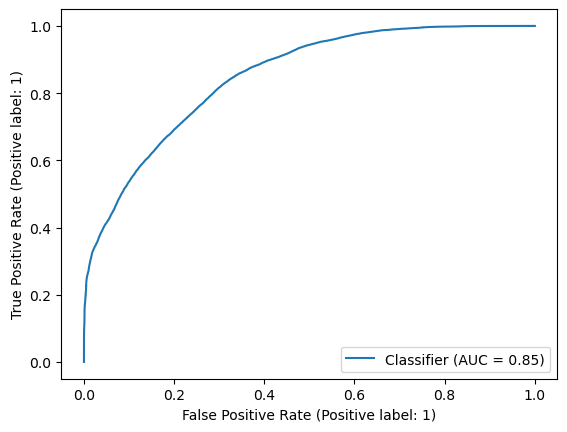

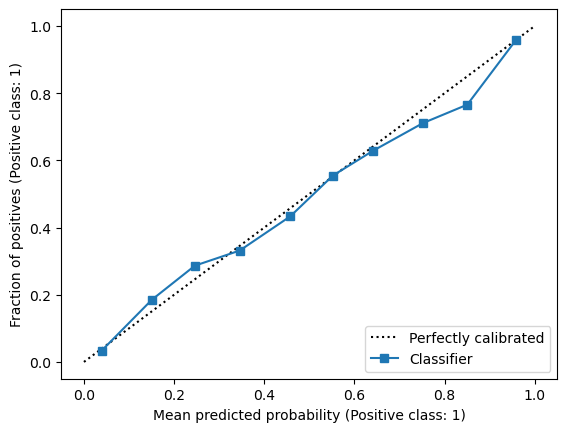

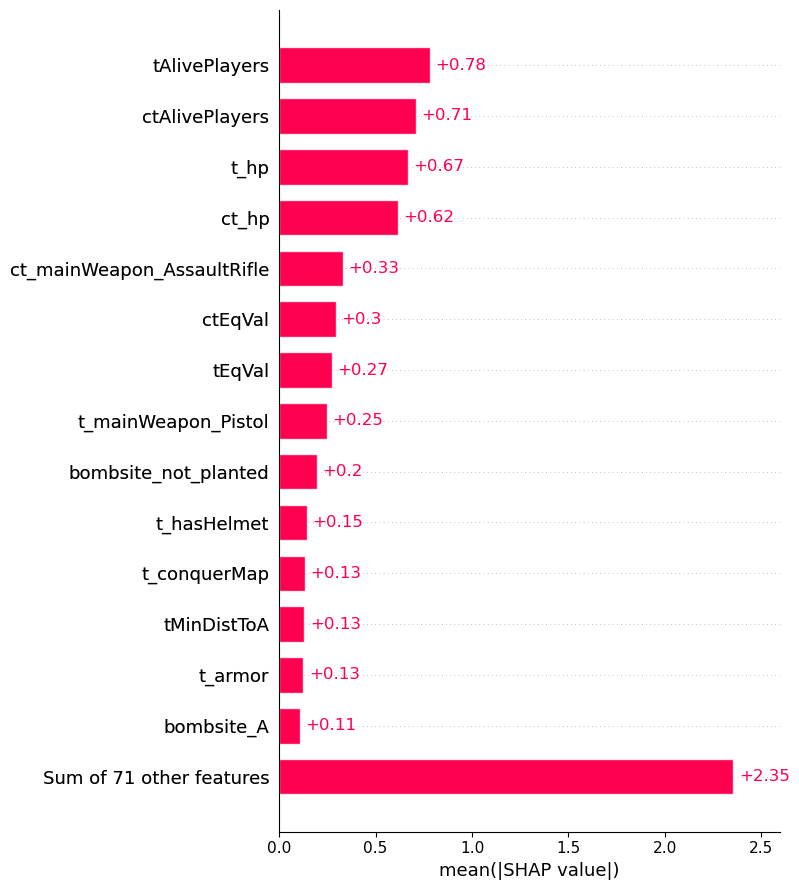

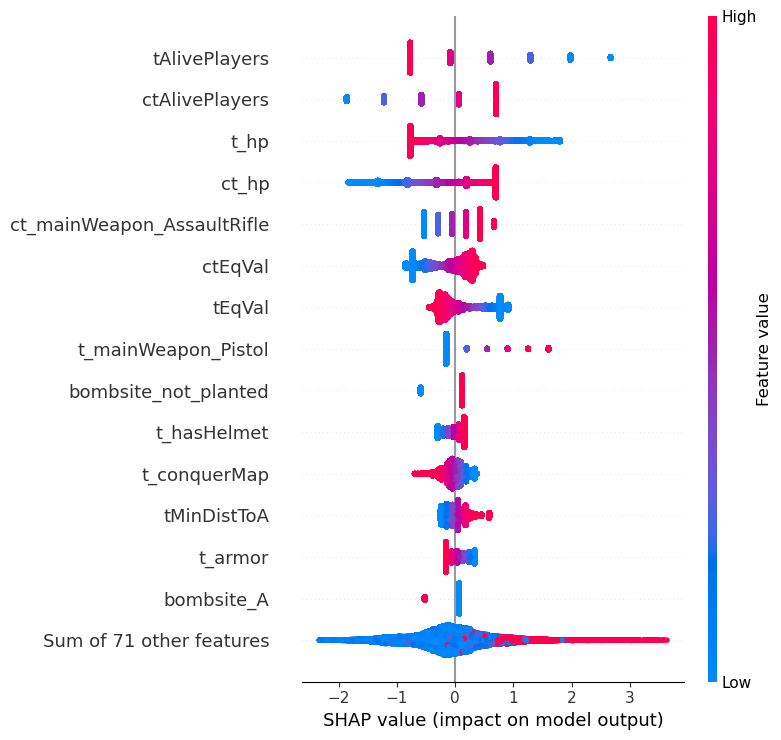

In [18]:
from sklearn.metrics import roc_auc_score
run_name = "Logistic Regression - Boruta Run"
additional_description = "Logistic Regression with Bayes Optimalization"
with mlflow.start_run(run_name=run_name, description=additional_description) as run:
        mlflow.log_params(model_logreg.get_params())
        mlflow.log_param("X_train.shape", X_train.shape)
        mlflow.log_param("X_test.shape", X_test.shape)
        mlflow.log_params({f"{key}_space": parameters[key] for key in parameters})

        y_proba = model_logreg.predict_proba(X_test)[:, 1]
        y_true = y_test
        features_names = X_train.columns.tolist()
        metrics = {}
        for threshold in np.arange(0.1, 1, 0.05):
            y_pred = (y_proba >= threshold).astype(int)
            metrics[f"accuracy_{threshold:.2f}"] = accuracy_score(y_true=y_true, y_pred=y_pred)
            metrics[f"precision_{threshold:.2f}"] = precision_score(y_true=y_true, y_pred=y_pred)
            metrics[f"recall_{threshold:.2f}"] = recall_score(y_true=y_true, y_pred=y_pred)
            metrics[f"f1_{threshold:.2f}"] = f1_score(y_true=y_true, y_pred=y_pred)
        metrics["roc_auc"] = roc_auc_score(y_true=y_true, y_score=y_proba)
        metrics["log_loss"] = log_loss(y_true=y_true, y_pred=y_proba)
        mlflow.log_metrics(metrics)
        
        
        if os.path.exists('artifacts'):
            shutil.rmtree('artifacts')
            os.makedirs('artifacts')
        
        if os.path.exists('models'):
            shutil.rmtree('models')
            os.makedirs('models')
            
        with open("artifacts/features.txt", 'w') as f:
            f.write(str(features_names))
            
        with open("models/model.pkl", "wb") as f:
            pickle.dump(model_logreg, f)

        roc_plot = RocCurveDisplay.from_predictions(y_pred=y_proba, y_true=y_true)
        roc_plot.figure_.savefig('artifacts/roc_auc.jpg')
        plt.show()
        
        calibration_curve = CalibrationDisplay.from_predictions(y_prob=y_proba, y_true=y_true, n_bins=10)
        calibration_curve.figure_.savefig('artifacts/calibration_curve.jpg')
        plt.show()
        
        shap.plots.bar(shap_values, show=False, max_display=15)
        plt.tight_layout()
        plt.savefig('artifacts/shap_importance.jpg')
        plt.show()
        
        shap.plots.beeswarm(shap_values, show=False, max_display=15)
        plt.tight_layout()
        plt.savefig('artifacts/shap_beeplot.jpg')
        plt.show()
        
        mlflow.log_artifacts("artifacts", artifact_path="plots_data")
        mlflow.log_artifacts("models", artifact_path="model")